[ 0.0528  0.      0.     -0.0321  0.0841  0.0661  0.0903  0.0782  0.
  0.0526  0.0914  0.1055 -0.0188 -0.0057  0.0748 -0.0087  0.0593 -0.1322
  0.     -0.0369 -0.0133 -0.0444 -0.0398  0.     -0.0043  0.0546 -0.0695
 -0.0124  0.0682 -0.0343 -0.0101  0.      0.0852  0.      0.      0.1046
  0.      0.0627  0.     -0.0373  0.1299  0.0702 -0.0434  0.     -0.0023
  0.1099  0.0479  0.0604 -0.0031  0.    ]


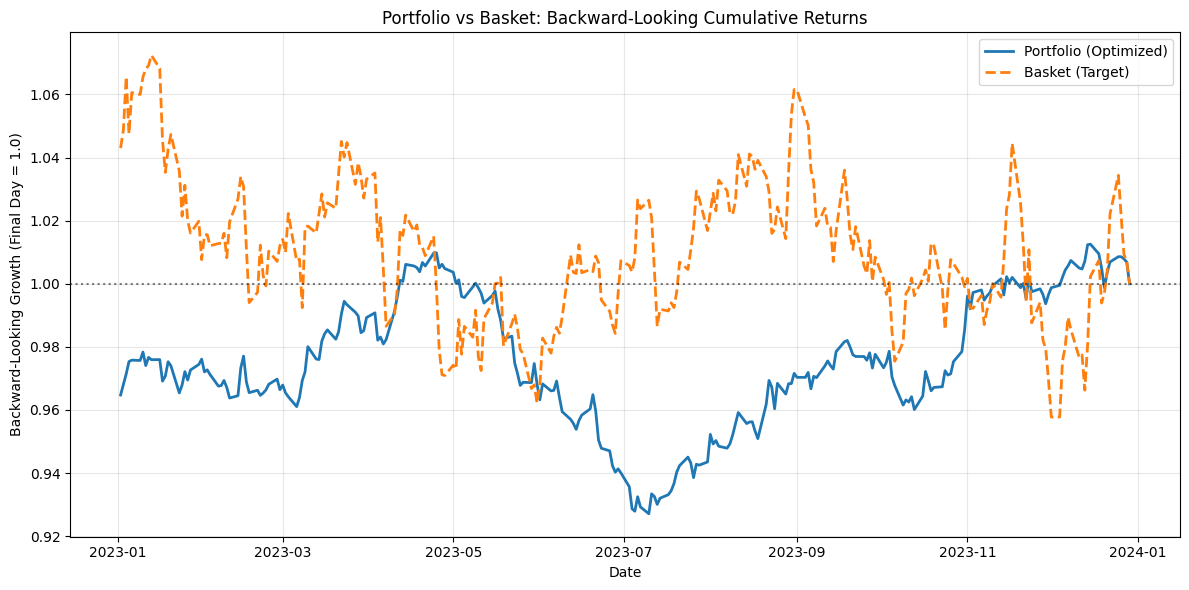


=== Backward-Looking Analysis ===
Day 1 normalized value (Portfolio): 0.9647
Day 1 normalized value (Basket): 1.0430
Final day normalized value: 1.0000 (by definition)

Interpretation: If you had $1 on the last day,
  you would have had $0.9647 on Day 1 (portfolio)
  you would have had $1.0430 on Day 1 (basket)


In [8]:
import random
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

start_date = '2023-01-01'
end_date = '2023-12-31'
num_rics = 50
mean_return = 0.0005
std_dev_return = 0.01
dates = pd.date_range(start=start_date, end=end_date, freq='B')
universe = [f'RIC_{{{i+1}}}' for i in range(num_rics)]
dummy_returns = np.random.normal(loc=mean_return, scale=std_dev_return, size=(len(dates), num_rics))
df_returns = pd.DataFrame(dummy_returns, index=dates, columns=universe)
cumulative_growth_factor = (1 + df_returns).cumprod()
df_prices = np.random.randint(low=10, high=100, size=num_rics, dtype=int) * cumulative_growth_factor
day1_prices = df_prices[df_prices.index==df_prices.index.min()].to_numpy().flatten()
basket_returns = np.random.normal(loc=mean_return, scale=std_dev_return, size=len(dates))
basket_prices = np.random.randint(low=10, high=100, size=1, dtype=int) * (1 + basket_returns).cumprod()
strikes = np.random.randint(low=10, high=50, size=num_rics, dtype=int)/100

basket_day1_notional = 1000000
basket_shares = basket_day1_notional / basket_prices[0]

FT = np.array(pd.DataFrame(df_returns.to_numpy()).fillna(0))

max_wtiv = 0.9
min_wtiv = 0.1

shorts_multiplier = -1
weight_longs = [0.05, 0.8]
weight_shorts = [0, 1]


price_matrix = df_prices.values
return_matrix = df_returns.values

# For buy-and-hold, daily dollar returns = shares[i] * price[t-1,i] * return[t,i]
lagged_prices = np.vstack([day1_prices.reshape(1, -1), price_matrix[:-1]])
dollar_return_factors = return_matrix * lagged_prices

# Now covariance matrix for dollar returns based on shares
Q_dollar = dollar_return_factors.T @ dollar_return_factors / len(dates)

# Basket dollar returns - basket_prices is already a numpy array
basket_lagged_prices = np.concatenate([[basket_prices[0]], basket_prices[:-1]])
basket_dollar_returns = basket_shares * basket_lagged_prices * basket_returns

c_dollar = -2 * (dollar_return_factors.T @ basket_dollar_returns) / len(dates)


opti_res = []

try:
    with open("shawn_results.html", "w") as out:
        shares = cp.Variable(len(universe))

        # x is the Day 1 weight - derived expression
        x = cp.multiply(shares, day1_prices) / basket_day1_notional

        # Decompose x into positive and negative parts
        pos_x = cp.Variable(len(universe), nonneg=True)
        neg_x = cp.Variable(len(universe), nonneg=True)

        pos_selection = cp.Variable(len(universe), boolean=True)
        neg_selection = cp.Variable(len(universe), boolean=True)

        # set bounds on weights
        weight_cons = []
        numMax_longs = math.floor(1/weight_longs[0]) if weight_longs[1]!=0 else len(universe)
        weight_cons += [cp.sum(pos_selection) <= numMax_longs,
                        pos_x <= weight_longs[1]*pos_selection]
        numMax_shorts = math.floor(1/weight_shorts[0]) if weight_shorts[0]!=0 else len(universe)
        weight_cons += [cp.sum(neg_selection) <= numMax_shorts,
                        neg_x <= weight_shorts[1]*neg_selection*-shorts_multiplier]
        weight_cons += [pos_x >= weight_longs[0]*pos_selection,
                        neg_x >= weight_shorts[0]*neg_selection*-shorts_multiplier]

        cons = [
            x == pos_x - neg_x,
            shares @ day1_prices == basket_day1_notional,
            cp.sum(neg_x) <= -shorts_multiplier,
            np.array(strikes) @ x <= max_wtiv,
            np.array(strikes) @ x >= min_wtiv,
        ] + weight_cons

        '''
        Save and display results if optimal solution found.'''
        objective = cp.Minimize(cp.quad_form(shares, Q_dollar) + c_dollar @ shares)
        problem = cp.Problem(objective, cons)
        try:
            problem.solve(solver=cp.SCIP, gp=False, scip_params={
              "limits/gap": 0.05,          # 1% optimality gap acceptable
              "parallel/maxnthreads": 4,   # Use 4 cores
          })
        except Exception as e:
            print(f'Error: {e}')
        if problem.status=='infeasible':
            print('Infeasible.')
        else:
            iter_id = '{}{}{}'.format(str(int(max_wtiv*10000)), str(int(weight_shorts[1]*10000)), str(int(weight_longs[1]*10000)))
            wts = x.value
            indices_x = [i for i in range(len(wts)) if abs(wts[i])>=0.0005]
            assets_x = np.array([universe[i] for i in indices_x])
            weights_x = np.array([wts[i] for i in indices_x])
            strikes_x = np.array([round(strikes[i],4) for i in indices_x])
            sorted_i = list(reversed(np.argsort(weights_x)))
            print(np.around(wts,4))
except KeyboardInterrupt:
    raise KeyboardInterrupt

if problem.status == 'optimal' or problem.status == 'optimal_inaccurate':
    optimal_shares = shares.value

    # Calculate portfolio and basket values over time (forward)
    portfolio_values = df_prices.values @ optimal_shares
    basket_values = basket_shares * basket_prices.flatten()

    # BACKWARD-LOOKING: Normalize to final day = 1.0
    # This shows "if I held these shares on the last day, what would
    # my value have been on each previous day?"
    portfolio_backward = portfolio_values / portfolio_values[-1]
    basket_backward = basket_values / basket_values[-1]

    # Plot backward-looking comparison
    plt.figure(figsize=(12, 6))
    plt.plot(dates, portfolio_backward, label='Portfolio (Optimized)', linewidth=2)
    plt.plot(dates, basket_backward, label='Basket (Target)', linewidth=2, linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Backward-Looking Growth (Final Day = 1.0)')
    plt.title('Portfolio vs Basket: Backward-Looking Cumulative Returns')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print(f"\n=== Backward-Looking Analysis ===")
    print(f"Day 1 normalized value (Portfolio): {portfolio_backward[0]:.4f}")
    print(f"Day 1 normalized value (Basket): {basket_backward[0]:.4f}")
    print(f"Final day normalized value: 1.0000 (by definition)")
    print(f"\nInterpretation: If you had $1 on the last day,")
    print(f"  you would have had ${portfolio_backward[0]:.4f} on Day 1 (portfolio)")
    print(f"  you would have had ${basket_backward[0]:.4f} on Day 1 (basket)")

In [9]:
sum([w for w in wts if w>0])

np.float64(1.5485733384483618)

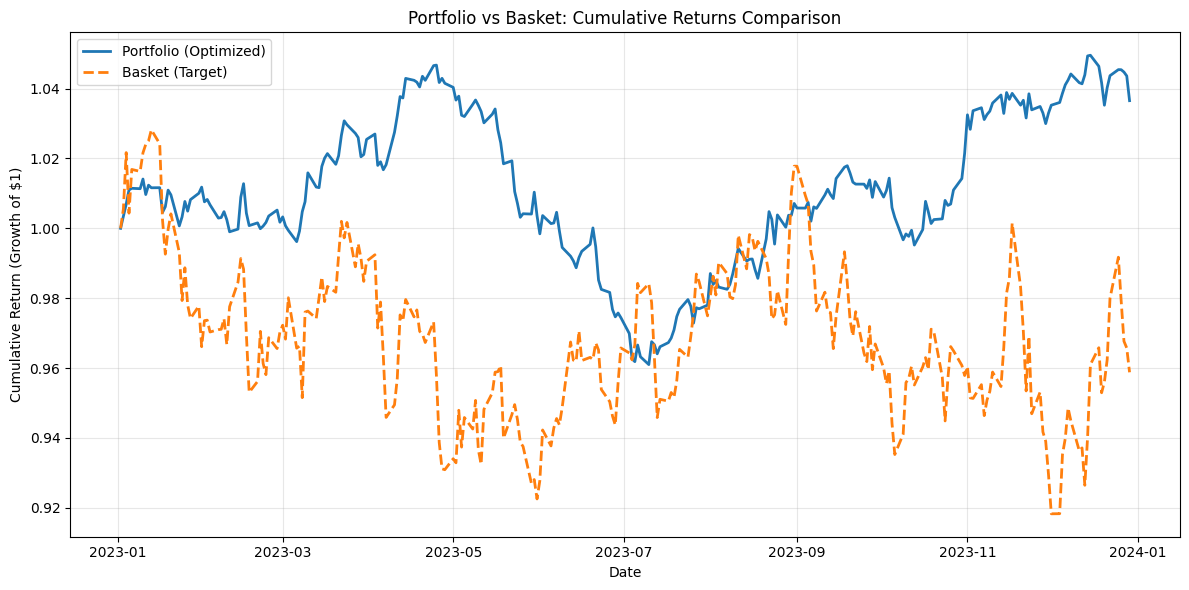


=== Performance Summary ===
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $1,036,547.86
Portfolio Total Return: 3.65%

Initial Basket Value: $1,000,000.00
Final Basket Value: $958,782.88
Basket Total Return: -4.12%

Tracking Error (Std Dev): $32,937.80
Final Tracking Difference: $77,764.98
Correlation: 0.3431


In [10]:
if problem.status == 'optimal' or problem.status == 'optimal_inaccurate':
    # Get optimal shares
    optimal_shares = shares.value

    # Calculate portfolio dollar values over time (buy-and-hold)
    # Portfolio value on day t = sum(shares[i] * price[t, i])
    portfolio_values = df_prices.values @ optimal_shares  # 252 x 1

    # Calculate basket dollar values over time
    basket_values = basket_shares * basket_prices.flatten()  # 252 x 1

    # Calculate daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    basket_returns_actual = np.diff(basket_values) / basket_values[:-1]

    # Calculate cumulative returns (growth of $1)
    portfolio_cumulative = np.cumprod(1 + portfolio_returns)
    basket_cumulative = np.cumprod(1 + basket_returns_actual)

    # Add initial value of 1.0 at the start
    portfolio_cumulative = np.concatenate([[1.0], portfolio_cumulative])
    basket_cumulative = np.concatenate([[1.0], basket_cumulative])

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(dates, portfolio_cumulative, label='Portfolio (Optimized)', linewidth=2)
    plt.plot(dates, basket_cumulative, label='Basket (Target)', linewidth=2, linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Growth of $1)')
    plt.title('Portfolio vs Basket: Cumulative Returns Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate tracking statistics
    tracking_diff = portfolio_values - basket_values
    tracking_error = np.std(tracking_diff)
    final_portfolio_value = portfolio_values[-1]
    final_basket_value = basket_values[-1]

    print(f"\n=== Performance Summary ===")
    print(f"Initial Portfolio Value: ${portfolio_values[0]:,.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
    print(f"Portfolio Total Return: {(final_portfolio_value/portfolio_values[0] - 1)*100:.2f}%")
    print(f"\nInitial Basket Value: ${basket_values[0]:,.2f}")
    print(f"Final Basket Value: ${final_basket_value:,.2f}")
    print(f"Basket Total Return: {(final_basket_value/basket_values[0] - 1)*100:.2f}%")
    print(f"\nTracking Error (Std Dev): ${tracking_error:,.2f}")
    print(f"Final Tracking Difference: ${tracking_diff[-1]:,.2f}")

    # Correlation
    corr = np.corrcoef(portfolio_returns, basket_returns_actual)[0, 1]
    print(f"Correlation: {corr:.4f}")

In [11]:
# See how much your weights changed
day1_weights = optimal_shares * day1_prices / basket_day1_notional
day252_weights = optimal_shares * df_prices.iloc[-1].values / portfolio_values[-1]

print("Weight changes from Day 1 to Day 252:")
for i in range(5):  # First 5 assets
    print(f"Asset {i}: {day1_weights[i]:.3f} → {day252_weights[i]:.3f} (change: {day252_weights[i]-day1_weights[i]:+.3f})")

Weight changes from Day 1 to Day 252:
Asset 0: 0.053 → 0.052 (change: -0.001)
Asset 1: 0.000 → 0.000 (change: +0.000)
Asset 2: 0.000 → 0.000 (change: +0.000)
Asset 3: -0.032 → -0.036 (change: -0.004)
Asset 4: 0.084 → 0.089 (change: +0.004)


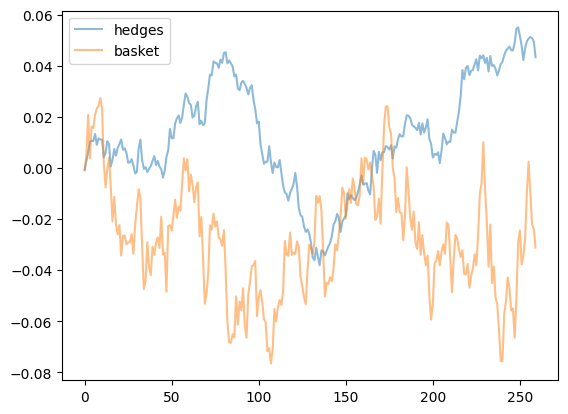

In [12]:
plt.plot(np.cumsum(FT@wts), alpha=0.5, label='hedges')
plt.plot(np.cumsum(basket_returns), alpha=0.5, label='basket')
plt.legend()

In [13]:
df_returns.values

array([[-1.82698381e-04,  7.66353244e-04, -6.34583100e-04, ...,
        -3.38037634e-04,  4.53814647e-03,  4.07009923e-03],
       [ 4.65999026e-03, -7.92697588e-03,  1.69787377e-02, ...,
        -7.85067713e-04, -9.58189893e-03,  6.36181317e-03],
       [-1.19290553e-02,  1.10076133e-03, -8.19814340e-03, ...,
         2.74422114e-03,  5.72389374e-03, -3.22334808e-03],
       ...,
       [-9.70536816e-03,  4.52672044e-05,  1.96543852e-03, ...,
        -6.66635938e-03,  6.06805378e-03, -1.58388357e-03],
       [-5.18754121e-03, -2.23288985e-03, -5.01565530e-03, ...,
         1.12343731e-02,  6.43350785e-03, -9.63850369e-03],
       [-1.03720955e-02, -1.02503228e-03,  5.14399557e-03, ...,
        -1.34020729e-02,  1.13603230e-02, -1.45813658e-02]])

Portfolio Optimization: Buy-and-Hold Tracking with Dollar-Variance Minimization
The Core Problem
You're trying to replicate a target basket's performance using a fixed portfolio of stocks that you'll hold for an entire year without rebalancing. The challenge is finding the right number of shares of each stock to buy today such that your portfolio's dollar value tracks the basket's dollar value as closely as possible over time.
This is fundamentally different from traditional portfolio optimization. Most approaches assume you can rebalance constantly to maintain target weights. Here, you buy shares once and hold them, meaning your actual portfolio weights will drift as prices change throughout the year.

Why Dollar-Based Optimization Matters
The key insight is that you need to think in dollar terms, not percentage terms.
Traditional mean-variance optimization works in percentage space. It asks: "What portfolio weights minimize variance of percentage returns?" This implicitly assumes you rebalance daily to maintain those weights. If you allocate 10% to a stock and it doubles, traditional optimization assumes you'll sell half to get back to 10%.
But you're not rebalancing. You hold fixed shares. So if you buy 1,000 shares of a $50 stock (initially 5% of your portfolio), and it rises to $100, you now have $100,000 worth of that stock. Your weight has shifted to roughly 10% automatically, without any action on your part.
This creates a path-dependency problem. The covariance structure in percentage space doesn't capture how dollar values actually evolve. You need to model the covariance of dollar returns, which accounts for the fact that larger positions (in dollar terms) contribute more to total portfolio variance.

Constructing the Dollar Covariance Matrix
The standard covariance matrix measures how percentage returns move together. But you need something different: how do the dollar contributions from each position covary?
The dollar return from holding shares of stock i on day t depends on three things: how many shares you own, what the stock was worth yesterday, and what return it earned today. Mathematically, this means multiplying the return by the lagged price.
By building a covariance matrix based on these dollar return factors rather than pure percentage returns, you're modeling the actual mechanics of a buy-and-hold portfolio. A stock that's expensive contributes more dollars to your portfolio's daily moves than a cheap stock with the same return percentage.
Similarly, you need to measure how each stock's dollar returns correlate with the basket's dollar returns. This captures not just whether they move together directionally, but whether they contribute similar dollar amounts to tracking error.

The Optimization Objective
You're minimizing the variance of the difference between your portfolio's dollar value and the basket's dollar value across all days in the year.
Think of it this way: each day, your portfolio is worth some amount, and the basket is worth some amount. The difference between these two numbers is your tracking error in dollars. Some days you're ahead, some days you're behind. The variance of these daily differences measures how consistently you track.
A low variance means you're reliably close to the basket. A high variance means you have big swings—sometimes you're way ahead, sometimes way behind. The optimization finds share quantities that keep these fluctuations as small as possible.
The quadratic form in the objective function is simply the algebraic expression of this variance. It accounts for both how volatile each stock is on its own and how stocks interact with each other through their correlations.

The Constraint Philosophy
Your constraints create a structured long-short portfolio with specific risk characteristics.
The budget constraint ensures you invest exactly one million dollars net. This doesn't mean you only buy one million dollars worth of stocks—you might buy 1.3 million long and sell 300,000 short for a net of one million. The constraint ensures your net exposure equals your capital.
The leverage constraint limits how much you can short. With a cap of 100% on shorts, if you're 30% short, you must be 130% long to maintain the one million net. This gives you a gross leverage of 1.6 times your capital. The optimization will use as much shorting as beneficial for tracking, up to this limit.
Position sizing constraints prevent the optimizer from putting all your capital into one or two stocks. The minimum and maximum bounds force diversification. The binary selection variables create a discrete choice: either you hold a meaningful position in a stock (between 5% and 80%), or you don't hold it at all. This prevents tiny, useless positions that add complexity without improving tracking.
The strike-weighted constraint is somewhat unusual and likely relates to an overlying derivatives structure. The strikes weight each position's contribution, and the constraint ensures this weighted sum stays within bounds. This might represent managing delta exposure if these equity positions are hedging options, or controlling some other risk factor that scales with these strikes.

Mixed-Integer Programming and Solution Quality
The binary selection variables make this a mixed-integer problem, which is computationally harder than standard quadratic programming. You're not just finding optimal continuous weights—you're also deciding which stocks to include at all.
The solver explores a combinatorial space. With 50 stocks and binary choices for each, there are technically 2 to the 50th power possible portfolios. The branch-and-bound algorithm intelligently searches this space by solving relaxed versions of the problem and systematically eliminating suboptimal branches.
The 5% gap tolerance is a practical compromise. Finding the absolute optimal solution might take hours or days. Accepting a solution that's within 5% of optimal typically cuts solve time to minutes. In practice, this is almost always acceptable because the uncertainty in your input parameters—the covariance estimates—is likely much larger than 5% anyway. You're optimizing based on historical data that may not perfectly predict the future.

Why Tracking Deteriorates Over Time
The backward-looking chart reveals a fundamental limitation of static replication: your tracking quality degrades as the year progresses.
Here's the mechanism: You optimize your share quantities based on the full year's covariance structure. On day one, your portfolio weights are exactly what the optimizer intended. But as prices change, your weights drift. A stock that rallies becomes a larger portion of your portfolio automatically. A stock that falls becomes smaller.
By mid-year, your actual weights may have drifted significantly from optimal. The optimizer "knew" this would happen—it saw the full year of data when solving—but it had to make a single choice of shares to hold the entire time. It found the best compromise across all 252 days.
The covariance structure itself may also shift. The relationships between stocks and the basket that held in January might differ from those in December. Market regimes change. Correlations are dynamic. Your static portfolio can't adapt.
This is why the divergence amplifies toward year-end. Early in the year, prices haven't moved much and your weights remain close to optimal. By late in the year, accumulated price changes have pulled your portfolio composition far from what would be optimal for tracking in that moment. You're stuck holding the position you established months ago.
The compounding effect matters too. If your portfolio underperforms the basket in month three, and then weights drift further from optimal in month four, these errors compound. You're not just dealing with individual daily tracking errors—you're dealing with the cumulative effect of many days of suboptimal tracking.

The Backward Normalization Perspective
Normalizing to the final day provides a different lens on performance than the traditional "growth of a dollar" view.
When you normalize to the end, you're asking: "Looking back from where I finished, what fraction of my terminal wealth existed at each earlier point?" If the normalized value is 0.85 on day one, it means that 85 cents of every dollar you ended with was already there at the start. The other 15 cents was earned throughout the year.
This perspective highlights relative growth trajectories. If your portfolio shows 0.90 on day one and the basket shows 0.85, both gained over the year, but the basket gained proportionally more. Your portfolio grew from 90 cents to a dollar—an 11% gain—while the basket grew from 85 cents to a dollar—an 18% gain.
The gap between the two lines represents missed opportunity. When the basket line is below yours early in the year, it means the basket experienced stronger gains that your static portfolio failed to capture. The optimization minimized variance of tracking error, not absolute tracking accuracy, so the portfolio might consistently underperform if that strategy reduced volatility of the difference.

Economic Interpretation
You've essentially built a synthetic replication vehicle. Rather than buying the basket directly, you're using a subset of securities in a leveraged long-short structure to approximate its behavior.
This approach is common when the basket itself isn't investable—perhaps it's a proprietary index, or transaction costs make buying all constituents prohibitive, or you want to add value through security selection. The long-short structure gives you flexibility to express negative views while maintaining net exposure.
The dollar-variance framework is appropriate precisely because you're not rebalancing. You're finding the best buy-and-hold approximation to a dynamic target. The optimization acknowledges that tracking will drift but minimizes the variability of that drift.
The results show both the power and limitations of this approach. You can achieve reasonable tracking with a concentrated portfolio, but the absence of rebalancing creates unavoidable degradation over time. Perfect static replication is generally impossible unless the basket's constituents have very stable return relationships and your securities span the basket's factor exposures.